# Train NN v0.8: Caveman 2.0 (WORK IN PROGRESS)

- generates N training samples with varied energies $K_{\alpha_1}$, energy splitting and ratios
- trains one MLP regressor for each parameter
- Also implements possibility to use classification on fixed energy grid
- The trained NNs are tested on training set, dev set and test set
- No optimization have been made.

Changes:

- Removed:

- Changes:
    - Changed some function parameters: Now X and Y are treated seperately 
- New:
    - global variable ob total number labels saved in a library
    - split_library(library): splits library into training, dev, and test set with 80%,10%,10% ratio
- Bug fixes


In [1]:
import MLforXES
from MLforXES.main import *

## Advanced Caveman

### Test with 1e3n1 on 1e3n1

In [2]:
"""
Defining (Hyper)Parameters
"""
exp = 3 # Exponent defining the size of the file
factor = 1
N = int(factor*10**(exp)) # Actual value
n = 1 # Number of spectra
comment = "test" # Comment for data file name
data_size = str(int(N/1000))+"k_" # Value for labeling the data (in "kilo samples") 
set_name = data_size+comment+"_library"
# Following the definition of the different models
model = MLPC(max_iter=1000, hidden_layer_sizes=(100,100),  activation="logistic", 
                 solver='sgd', learning_rate = 'adaptive', batch_size=1, momentum = 0.9,
                 verbose = True, early_stopping=False, tol = 1e-6)

In [4]:
build_library(N, n, random_states=True, noise = True, Set = "1e3n2", verbosity=True, poisson=2000)

Progress: 0/1000, time for loop: 0.01s
Progress: 100/1000, time for loop: 0.19s
Progress: 200/1000, time for loop: 0.19s
Progress: 300/1000, time for loop: 0.20s
Progress: 400/1000, time for loop: 0.19s
Progress: 500/1000, time for loop: 0.20s
Progress: 600/1000, time for loop: 0.19s
Progress: 700/1000, time for loop: 0.20s
Progress: 800/1000, time for loop: 0.20s
Progress: 900/1000, time for loop: 0.19s
Time for generating the temp_1.sublibrary set: 1.9801719188690186
+++++++++++++
Time for generating library: 2.47s
+++++++++++++


In [6]:
library = load_library(Set = "1e3n2", fraction = 100, verbosity=True)

Time for reading temp_1.sublibrary set: 0.00s
Time for unpacking: 0.20s
+++++++++++
Time for loading the library: 0.21s
+++++++++++


In [7]:
predict_train, predict_dev, predict_proba_train, predict_proba_dev = test_envir(library, n, model, verbosity=2, scaling=False, pca = False, k = 30)

Training time: 443.62 
Training score: 0.29 


C:\Users\Lukas\Anaconda3\lib\site-packages\plotly\matplotlylib\renderer.py:384: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

C:\Users\Lukas\Anaconda3\lib\site-packages\plotly\matplotlylib\renderer.py:481: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Mean error per prediction in training set: 0.02 on energy label
Mean error per prediction in dev set: 0.02 on energy label


In [111]:
Xtrain, Ytrain, Xdev, Ydev, Xtest, Ytest = split_library(library, "energy_label")
Xtrain_en, Ytrain_en, Xdev_en, Ydev_en, Xtest_en, Ytest_en = split_library(library, "energies_binned")
bins = GRID_TARGET[0:len(GRID_TARGET)-1]
bins_int = bins*100
bins_int = bins_int.astype(int)
for k in range(1):
    plt.xlim(2008,2018)
    plt.plot(GRID_FEATURES, Xdev[k])
    plt.plot(Ydev_en[k,0], 0.01, 'ro')
    plt.plot(Ydev_en[k,1], 0.01, 'ro')
    plt.plot(Ydev_en[k,2], 0.01, 'ro')
    plt.bar(bins, predict_proba_dev[k][:])
    #plt.bar(bins, predict_proba_dev[1][k][:])
    plt.grid(True)
    plotly_show()

In [112]:
import peakutils
def gaussfit(data, ecenter = 2013.5, width = 0.1):
    '''use guessfit.best_values and gauessfit.chisqr, etc. to get
    parameters from the fit'''
    indices = np.where((GRID_TARGET>ecenter-0.1)&(GRID_TARGET<ecenter+0.1))[0]
    yvalues = data[indices]
    xrange = GRID_TARGET[indices]
    gaussmod = lmfit.models.GaussianModel()
    gausspars = gaussmod.guess(yvalues, x=xrange)
    gaussfit = gaussmod.fit(yvalues, params=gausspars, x=xrange)
    return gaussfit

In [272]:
def prob_stats(prob_data):
    """
    Fit Gaussian distributions to probability distribution of target grid
    by searching peaks with peakutils. Returns multidimensional array of fits. 
    """
    # Fit Gaussians to all found peaks
    N = len(prob_data)
    fit = []
    for i in range(N):
        data = prob_data[i]
        index = peakutils.indexes(data, thres=0.5, min_dist=10)
        subarray = np.array([])
        for j in range(len(index)):
            mu = GRID_TARGET[index[j]]
            subarray = np.append(subarray, gaussfit(data, ecenter = mu, width = 0.1))
        fit.append(subarray)
    # Plot number of fits
    peaks = np.zeros(10)
    header = np.zeros(10)
    for i in range(10):
        header[i] = i
    for i in range(len(fit)):
        for j in range(10):
            if len(fit[i]) == j:
                peaks[j] += 1
    print("Peaks fitted per spectrum: ")
    print(header)
    print(peaks)
    # Plot information about the mean width of all fits
    omegas = np.array([])
    for i in range(len(fit)):
        for j in range(len(fit[i])):
            omegas = np.append(omegas, fit[i][j].best_values['sigma'])
    print("Mean standart deviation: %3.3f eV" % np.mean(omegas))        
    plt.plot(omegas)
    plt.title("Standart deviation per fit")
    plt.xlabel("Fit number")
    plt.ylabel("Standart deviation in eV")
    plotly_show()
    return fit

In [273]:
fit = prob_stats(predict_proba_dev)

Peaks fitted per spectrum: 
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
[  0.  95.   5.   0.   0.   0.   0.   0.   0.   0.]
Mean standart deviation: 0.051 eV


In [219]:
plt.plot(GRID_TARGET, fit[0][0].eval(x=GRID_TARGET), "r", lw=2)
plt.bar(GRID_TARGET[0:len(GRID_TARGET)-1], predict_proba_dev[0])
plotly_show()

In [142]:
omega = np.array([])
for i in range(len(fit)):
    omega = np.append(omega, fit[i].best_values['sigma'])
plt.plot(omega)
plotly_show()

### Testing 1e4n1 on 1e4n1

In [144]:
"""
Defining (Hyper)Parameters
"""
exp = 4 # Exponent defining the size of the file
factor = 1
N = int(factor*10**(exp)) # Actual value
n = 1 # Number of spectra
comment = "test" # Comment for data file name
data_size = str(int(N/1000))+"k_" # Value for labeling the data (in "kilo samples") 
set_name = data_size+comment+"_library"
# Following the definition of the different models
model = MLPC(max_iter=1000, hidden_layer_sizes=(100,100),  activation="logistic", 
                 solver='sgd', learning_rate = 'adaptive', batch_size=1, momentum = 0.9,
                 verbose = True, early_stopping=False, tol = 1e-6)

In [146]:
build_library(N, n, random_states=True, noise = True, Set = "1e4n1", verbosity=True, poisson=2000)

Progress: 0/10000, time for loop: 0.01s
Progress: 1000/10000, time for loop: 1.99s
Progress: 2000/10000, time for loop: 2.00s
Progress: 3000/10000, time for loop: 2.02s
Progress: 4000/10000, time for loop: 2.02s
Progress: 5000/10000, time for loop: 1.99s
Progress: 6000/10000, time for loop: 2.03s
Progress: 7000/10000, time for loop: 2.00s
Progress: 8000/10000, time for loop: 1.97s
Progress: 9000/10000, time for loop: 1.99s
Time for generating the temp_1.sublibrary set: 20.360070943832397
+++++++++++++
Time for generating library: 25.45s
+++++++++++++


In [147]:
library = load_library(Set = "1e4n1", fraction = 100, verbosity=True)

Time for reading temp_1.sublibrary set: 0.08s
Time for unpacking: 1.95s
+++++++++++
Time for loading the library: 1.97s
+++++++++++


### Test on 1e3n2

In [2]:
"""
Defining (Hyper)Parameters
"""
exp = 3 # Exponent defining the size of the file
factor = 1
N = int(factor*10**(exp)) # Actual value
noisee = True
n = 2 # Number of spectra
comment = "test" # Comment for data file name
data_size = str(int(N/1000))+"k_" # Value for labeling the data (in "kilo samples") 
set_name = data_size+comment+"_library"
x = np.arange(2008,2018,0.05) # Grid for creating and importing data
# Following the definition of the different models
model = MLPC(max_iter=100, hidden_layer_sizes=(350,350),  activation="logistic", 
                 solver='sgd', learning_rate = 'adaptive', batch_size=1, momentum = 0.9,
                 verbose = True, early_stopping=False, tol = 1e-6)

In [21]:
build_library(N, n, random_states=True, noise = True, Set = "1e3n2", verbosity=True)

Error: File already exists! 


0

In [3]:
library = load_library(Set = "1e3n2", fraction = 100, verbosity=True)

FileNotFoundError: [Errno 2] No such file or directory: './data/1e3n2.tar.bz2'

In [9]:
#predict_train, predict_dev, predict_proba_train, predict_proba_dev = test_envir(library, n, model, verbosity=2, scaling=False, pca = False, k = 30)

Training time: 1147.84 
Training score: 0.01 


C:\Users\Lukas\Anaconda3\lib\site-packages\plotly\matplotlylib\renderer.py:384: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

C:\Users\Lukas\Anaconda3\lib\site-packages\plotly\matplotlylib\renderer.py:481: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Mean error per prediction in training set: 461.15 on energy label
Mean error per prediction in dev set: 584.43 on energy label


In [23]:
Xtrain, Ytrain, Xdev, Ydev, Xtest, Ytest = split_library(library, "energy_label")
Xtrain_en, Ytrain_en, Xdev_en, Ydev_en, Xtest_en, Ytest_en = split_library(library, "energies_binned")
bins = GRID_TARGET[0:len(GRID_TARGET)-1]
bins_int = bins*100
bins_int = bins_int.astype(int)
for k in range(20):
    plt.xlim(2008,2018)
    plt.plot(GRID_FEATURES, Xdev[k])
    plt.plot(Ydev_en[k,0], 0.01, 'ro')
    plt.plot(Ydev_en[k,1], 0.01, 'ro')
    plt.plot(Ydev_en[k,2], 0.01, 'ro')
    plt.bar(bins, predict_proba_dev[k][:])
    #plt.bar(bins, predict_proba_dev[1][k][:])
    plt.grid(True)
    plotly_show()

In [18]:
print(np.shape(predict_proba_dev[0]))
print(np.shape(GRID_TARGET[0:len(GRID_TARGET)-1]))

(240,)
(240,)


### Improving grid

In [2]:
"""
Defining (Hyper)Parameters
"""
exp = 3 # Exponent defining the size of the file
factor = 1
N = int(factor*10**(exp)) # Actual value
noisee = True
n = 1 # Number of spectra
comment = "test" # Comment for data file name
data_size = str(int(N/1000))+"k_" # Value for labeling the data (in "kilo samples") 
set_name = data_size+comment+"_library"
# Following the definition of the different models
model = MLPC(max_iter=1000, hidden_layer_sizes=(100,100),  activation="logistic", 
             solver='sgd', learning_rate = 'adaptive', batch_size=1, momentum = 0.9,
             verbose = True, early_stopping=False, tol = 1e-6)

In [7]:
library = np.array([])
for i in range(6):
    name = "N1e4_n1_p"+str(i+1)+"e3"
    poissonc = float((1)*10**(i))
    print(poissonc)
    build_library(N, n, random_states=True, noise = True, Set = name, verbosity=False, poisson=poissonc)
    library = np.append(library, load_library(Set = name, fraction = 100, verbosity=False))

1.0
Poissoncnts (build): 1.000000
Poissoncnts (gen): 1.000000
10.0
Poissoncnts (build): 10.000000
Poissoncnts (gen): 10.000000
100.0
Poissoncnts (build): 100.000000
Poissoncnts (gen): 100.000000
1000.0
Poissoncnts (build): 1000.000000
Poissoncnts (gen): 1000.000000
10000.0
Poissoncnts (build): 10000.000000
Poissoncnts (gen): 10000.000000
100000.0
Poissoncnts (build): 100000.000000
Poissoncnts (gen): 100000.000000


In [9]:
Xtrain = np.array([])
Ytrain = np.array([])
Xdev = np.array([])
Ydev = np.array([])
Xtest = np.array([])
Ytest = np.array([])
for i in range(6):
    xtrain, ytrain, xdev, ydev, xtest, ytest = split_library(library[i], key = "energy_label")
    Xtrain = np.append(Xtrain, xtrain).reshape(i+1,len(xtrain),len(xtrain[0]))
    Ytrain = np.append(Ytrain, ytrain).reshape(i+1,len(ytrain))
    Xdev = np.append(Xdev, xdev).reshape(i+1,len(xdev),len(xdev[0]))
    Ydev = np.append(Ydev, ydev).reshape(i+1,len(ydev))
    Xtest = np.append(Xtest, xtest).reshape(i+1,len(xtest),len(xtest[0]))
    Ytest = np.append(Ytest, ytest).reshape(i+1,len(ytest))

In [10]:
print(np.shape(Xdev))

(6, 100, 200)


In [12]:
s = 0
for i in range(6):
    plt.xlim(2008,2018)
    plt.plot(GRID_FEATURES, Xdev[i][s])
    #plt.plot(Ydev[i][s], 0.01, 'ro')
    #plt.plot(Ydev[k,1], 0.01, 'ro')
    #plt.bar(GRID_FEATURES, predict_proba_dev[0][k][:])
    #plt.bar(bins, predict_proba_dev[1][k][:])
    plt.grid(True)
plotly_show()

In [7]:
predict_train, predict_dev, predict_proba_train, predict_proba_dev = test_envir(library[5], n, model, verbosity=2, scaling=False, pca = False, k = 30)

Training time: 487.50 
Training score: 0.79 


C:\Users\Lukas\Anaconda3\lib\site-packages\plotly\matplotlylib\renderer.py:384: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

C:\Users\Lukas\Anaconda3\lib\site-packages\plotly\matplotlylib\renderer.py:481: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Mean error per prediction in training set: 0.02 on energy label
Mean error per prediction in dev set: 0.02 on energy label


In [10]:
Xtrain, Ytrain, Xdev, Ydev, Xtest, Ytest = split_library(library[0], "energy_label")
Xtrain_en, Ytrain_en, Xdev_en, Ydev_en, Xtest_en, Ytest_en = split_library(library[0], "energies_binned")
bins = GRID_TARGET[0:len(GRID_TARGET)-1]
bins_int = bins*100
bins_int = bins_int.astype(int)
for k in range(5):
    plt.xlim(2008,2018)
    plt.plot(GRID_FEATURES, Xdev[k])
    plt.plot(Ydev_en[k,0], 0.01, 'ro')
    plt.plot(Ydev_en[k,1], 0.01, 'ro')
    plt.plot(Ydev_en[k,2], 0.01, 'ro')
    plt.bar(bins, predict_proba_dev[k][:])
    #plt.bar(bins, predict_proba_dev[1][k][:])
    plt.grid(True)
    plotly_show()

In [13]:
import peakutils
from matplotlib import pyplot
from peakutils.plot import plot as pplot
%matplotlib inline

[117 136]
[ 2013.85  2014.8 ] [ 0.701  1.021]


Text(0.5,1,'First estimate')

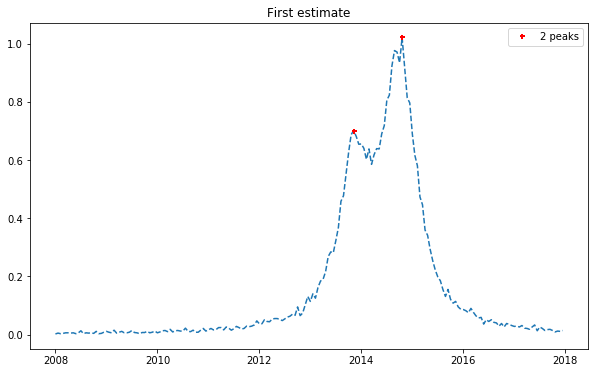

In [49]:
indexes = peakutils.indexes(Xdev[3][0], thres=0.5, min_dist=10)
print(indexes)
print(GRID_FEATURES[indexes], Xdev[3][0][indexes])
pyplot.figure(figsize=(10,6))
pplot(GRID_FEATURES, Xdev[3][0], indexes)
pyplot.title('First estimate')

In [48]:
import pylab as plb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

In [51]:
# initial parameter
def gaussian(x, mu, sigma, A):
    return (A/(sigma*np.sqrt(2*np.pi)))*np.exp(-1/2*np.square((x-mu)/sigma))

In [59]:
GRID_FEATURES[indexes][0]

2013.8499999999947

In [98]:
mu = GRID_FEATURES[indexes][0]
sigma = SIGMA1
param_bounds=([-np.inf,0,-np.inf],[np.inf,mu+0.1,np.inf])
popt,pcov = curve_fit(gaussian,GRID_FEATURES,Xdev[3][0],p0=[1,mu,sigma], bounds=param_bounds)

In [99]:
plt.plot(GRID_FEATURES,gaussian(GRID_FEATURES,*popt),'r',label='fit')
plt.plot(GRID_FEATURES, Xdev[3,0])
plotly_show()